In [1]:

import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import os
import gc

print("--- Phase 1: Starting Data Preparation ---")

BASE_INPUT_PATH = '/kaggle/input/downsized-data'
IMAGE_DIR = os.path.join(BASE_INPUT_PATH, 'nih_images_resized_256/')
CSV_PATH = os.path.join(BASE_INPUT_PATH, 'Data_Entry_2017_stratified_downsized.csv')

IMG_SIZE = 224
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 1024
AUTOTUNE = tf.data.AUTOTUNE


df = pd.read_csv(CSV_PATH)
final_14_labels = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
    'Pneumonia', 'Pneumothorax', 'No Finding'
]
for label in final_14_labels:
    df[label] = df['Finding Labels'].str.lower().apply(
        lambda finding_string: 1 if label.lower() in str(finding_string) else 0
    )
df['image_path'] = df['Image Index'].apply(lambda x: os.path.join(IMAGE_DIR, x))


train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)
print(f"Training set size: {len(train_df)} images")
print(f"Validation set size: {len(val_df)} images")

# --- Preprocessing and Augmentation Functions ---
def parse_function(image_path, labels):
    img_raw = tf.io.read_file(image_path)
    img = tf.io.decode_png(img_raw, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.grayscale_to_rgb(img)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img, labels

def augment_function(image, labels):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.05)
    return image, labels

def create_dataset(dataframe):
    image_paths = dataframe['image_path'].values
    labels = dataframe[final_14_labels].values.astype(np.float32)
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = ds.map(parse_function, num_parallel_calls=AUTOTUNE)
    return ds

train_dataset = (
    create_dataset(train_df)
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
    .map(augment_function, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)
validation_dataset = (
    create_dataset(val_df)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

print("Deleting DataFrames to free up memory...")
del df, train_df, val_df
gc.collect()

print("\nComplete: `train_dataset` and `validation_dataset` are ready. ---")

2025-06-27 19:46:34.045587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751053594.278824      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751053594.342223      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--- Phase 1: Starting Data Preparation ---
Training set size: 48706 images
Validation set size: 8596 images


2025-06-27 19:46:50.551215: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Deleting DataFrames to free up memory...

Complete: `train_dataset` and `validation_dataset` are ready. ---


In [2]:
import tensorflow as tf
import os

input_dir = '/kaggle/input/nih-phase-3-fine-tuning'
model_path = os.path.join(input_dir, 'best_fine_tuned_model.keras')

print(f"Loading the previously fine-tuned model from: {model_path}")
model = tf.keras.models.load_model(model_path)


model.get_layer('mobilenetv2_1.00_224').trainable = True
print("\nBase model is trainable.")

VERY_LOW_LEARNING_RATE = 1e-6 

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=VERY_LOW_LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc_roc', multi_label=True)]
)

print(f"\nModel re-compiled for further fine-tuning with a learning rate of {VERY_LOW_LEARNING_RATE}.")
model.summary()

Loading the previously fine-tuned model from: /kaggle/input/nih-phase-3-fine-tuning/best_fine_tuned_model.keras

Base model is trainable.

Model re-compiled for further fine-tuning with a learning rate of 1e-06.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │          17,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,275,918 (8.68 MB)

 Trainable params: 2,241,806 (8.55 MB)

 Non-trainable params: 34,112 (133.25 KB)


--- Starting Further Fine-Tuning (Phase 4) ---
Epoch 1/5
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - auc_roc: 0.7929 - loss: 0.1994
Epoch 1: val_auc_roc improved from -inf to 0.77102, saving model to best_further_fine_tuned_model.keras
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 5388s 2s/step - auc_roc: 0.7929 - loss: 0.1994 - val_auc_roc: 0.7710 - val_loss: 0.2081
Epoch 2/5
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - auc_roc: 0.7951 - loss: 0.1989
Epoch 2: val_auc_roc improved from 0.77102 to 0.77174, saving model to best_further_fine_tuned_model.keras
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 5733s 2s/step - auc_roc: 0.7951 - loss: 0.1989 - val_auc_roc: 0.7717 - val_loss: 0.2081
Epoch 3/5
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - auc_roc: 0.7973 - loss: 0.1988
Epoch 3: val_auc_roc did not improve from 0.77174
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 5533s 2s/step - auc_roc: 0.7973 - loss: 0.1988 - val_auc_roc: 0.7707 - val_loss: 0.2079
Epoch 4/5
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - auc_roc: 0.8010 - loss: 0

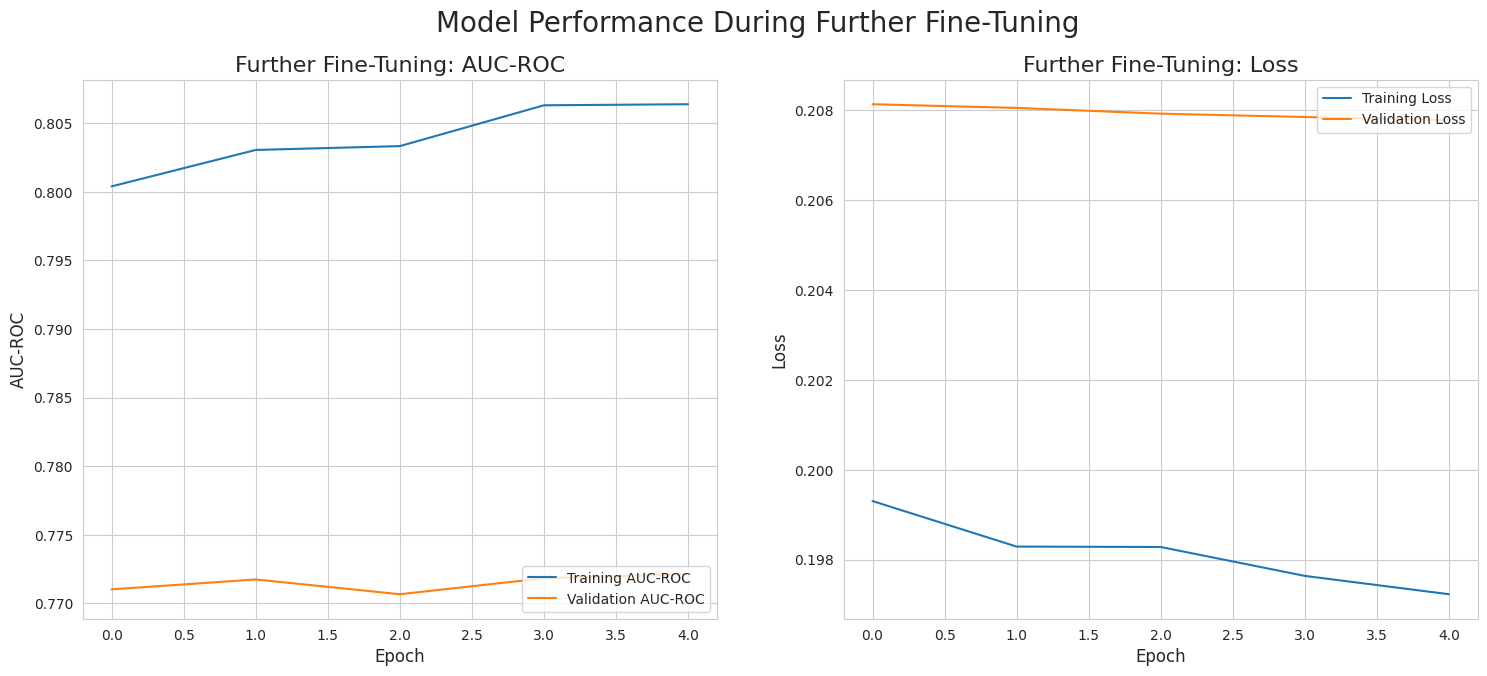

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

further_fine_tune_checkpoint = ModelCheckpoint(
    filepath='best_further_fine_tuned_model.keras',
    monitor='val_auc_roc',
    mode='max',
    save_best_only=True,
    verbose=1
)


early_stopping = EarlyStopping(
    monitor='val_auc_roc',
    mode='max',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

print("\n--- Starting Further Fine-Tuning (Phase 4) ---")

history_further_fine_tune = model.fit(
    train_dataset, 
    validation_data=validation_dataset, 
    epochs=5,
    callbacks=[further_fine_tune_checkpoint, early_stopping]
)

print("\n--- Further Fine-Tuning Complete ---")
np.save('further_fine_tune_history.npy', history_further_fine_tune.history)
print("Further fine-tuning history saved to 'further_fine_tune_history.npy'")

# --- Plot the results of this new phase ---
plt.figure(figsize=(18, 7))
sns.set_style("whitegrid")

# Plot AUC-ROC
plt.subplot(1, 2, 1)
plt.plot(history_further_fine_tune.history['auc_roc'], label='Training AUC-ROC')
plt.plot(history_further_fine_tune.history['val_auc_roc'], label='Validation AUC-ROC')
plt.title('Further Fine-Tuning: AUC-ROC', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC-ROC', fontsize=12)
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_further_fine_tune.history['loss'], label='Training Loss')
plt.plot(history_further_fine_tune.history['val_loss'], label='Validation Loss')
plt.title('Further Fine-Tuning: Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')

plt.suptitle('Model Performance During Further Fine-Tuning', fontsize=20)
plt.show()